In [1]:
!pip install catboost -q
!pip install GPUtil -q
!pip install pytorch-tabnet -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

import gc
import os
from numpy import mean
from numpy import std

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage() 
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [4]:
df = pd.read_fwf('./drive/MyDrive/german.data-numeric',  header=None,
                 names=["x1", "x2", "x3", 'x4', 'x5', 'x6', 'x7','x8',
                        'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
                        'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'label'])

In [5]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,label
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


In [6]:
df.label = df.label.map({1: 0, 2: 1})

In [7]:
######### Pre-processing #########

In [8]:
#### Detect global outliers
ISF = IsolationForest(random_state=0)
df = df[ISF.fit_predict(df) == 1]

In [9]:
##### Detect local outliers
LOF = LocalOutlierFactor(n_neighbors=2)
df = df[LOF.fit_predict(df) == 1]

In [10]:
cat_cols= ['x1', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 
           'x18', 'x19', 'x20', 'x21', 'x23', 'x24']

In [11]:
df.drop('x22', axis = 1)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x15,x16,x17,x18,x19,x20,x21,x23,x24,label
0,1,6,4,12,5,5,3,4,1,67,...,1,0,0,1,0,0,1,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,1,0,0,1,0,0,1,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,1,0,0,1,0,0,1,1,0,0
6,4,24,2,28,3,5,3,4,2,53,...,1,0,0,1,0,0,1,0,1,0
8,4,12,2,31,4,4,1,4,1,61,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,2,24,4,17,1,5,3,2,2,48,...,1,0,0,1,0,0,1,1,0,0
993,1,36,2,40,1,1,3,3,2,30,...,1,0,0,1,0,0,1,0,0,0
994,4,12,2,24,5,5,3,3,3,50,...,1,1,0,1,0,0,1,0,1,0
995,4,12,2,17,1,4,2,4,1,31,...,1,0,0,1,0,0,1,1,0,0


In [12]:
#One-Hot-Endcoding
df = pd.get_dummies(df, columns = cat_cols)

In [13]:
df.shape

(642, 64)

In [14]:
y = df.label
df.drop('label', axis = 1, inplace = True)

In [15]:
#Normalize
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [16]:
#Oversampling
sm = BorderlineSMOTE(random_state=42, n_jobs = -1)
X, y = sm.fit_resample(X, y)

In [17]:
gc.collect()

208

In [18]:
############# Base model ############

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify = y)
print('Size of train dataframe: ', X_train.shape)
print('Size of train dataframe: ', y_train.shape)
print('Size of test dataframe: ', X_test.shape)
print('Size of train dataframe: ', y_test.shape)

Size of train dataframe:  (788, 63)
Size of train dataframe:  (788,)
Size of test dataframe:  (198, 63)
Size of train dataframe:  (198,)


In [20]:
n_fold = 5

In [21]:
############### Random Forest model #############

In [22]:
rf = RandomForestClassifier(n_estimators=361,
                               random_state=42,
                           n_jobs = -1,
                           verbose = 0)

In [23]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_rf = []
auc_score_rf = []
f1_rf = []
meta_train_rf = []
meta_test_rf = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    rf.fit(train_X, train_y)
    ####meta
    meta_train_rf = np.append(meta_train_rf, rf.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_rf) == 0:
        meta_test_rf = rf.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_rf = np.add(meta_test_rf, rf.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    
    yhat = rf.predict(X_test)
    acc_score_rf.append(accuracy_score(yhat,y_test))
    auc_score_rf.append(roc_auc_score(yhat,y_test))
    f1_rf.append(f1_score(yhat,y_test))
    i += 1
meta_test_rf = np.divide(meta_test_rf, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###Random Forest Classifier###

Accuracy: 0.8848484848484848 +- 0.010301049522409683
ROC-AUC: 0.8855061366286334 +- 0.010186919014260911
F1-Score: 0.882654363483379 +- 0.011041239347541068
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        99
           1       0.91      0.87      0.89        99

    accuracy                           0.89       198
   macro avg       0.89      0.89      0.89       198
weighted avg       0.89      0.89      0.89       198



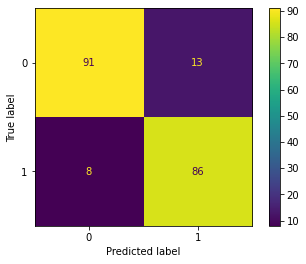

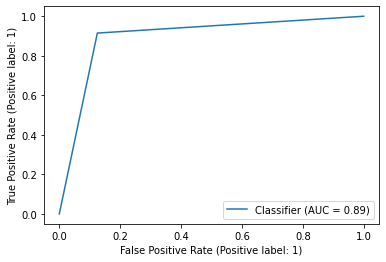

In [24]:
print("###Random Forest Classifier###\n")
print("Accuracy: " + str(mean(acc_score_rf)) + " +- "+ str(std(acc_score_rf)))
print("ROC-AUC: " + str(mean(auc_score_rf)) + " +- " + str(std(auc_score_rf)))
print("F1-Score: " + str(mean(f1_rf)) +" +- "+ str(std(f1_rf)))

yhat = rf.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [25]:
gc.collect()

2591

In [26]:
######### LightGBM model ###########

In [27]:
lgb = LGBMClassifier(
                boosting_type='gbdt',
                max_depth=10,
                learning_rate=0.05,
                n_estimators=450,
                objective = 'binary',
                random_state=42
)

In [28]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lgb = []
auc_score_lgb = []
f1_lgb = []
meta_train_lgb = []
meta_test_lgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_lgb = np.append(meta_train_lgb, lgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_lgb) == 0:
        meta_test_lgb = lgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_lgb = np.add(meta_test_lgb, lgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = lgb.predict(X_test)
    acc_score_lgb.append(accuracy_score(yhat,y_test))
    auc_score_lgb.append(roc_auc_score(yhat,y_test))
    f1_lgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_lgb = np.divide(meta_test_lgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###LightGBM Classifier###

Accuracy: 0.8717171717171717 +- 0.01220509694302482
ROC-AUC: 0.8733802172378919 +- 0.013747985291560664
F1-Score: 0.8699879752655845 +- 0.008656589560985547
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        99
           1       0.94      0.83      0.88        99

    accuracy                           0.89       198
   macro avg       0.89      0.89      0.89       198
weighted avg       0.89      0.89      0.89       198



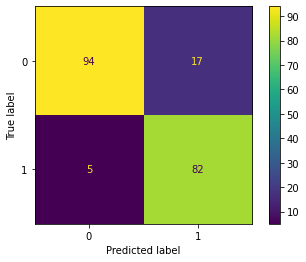

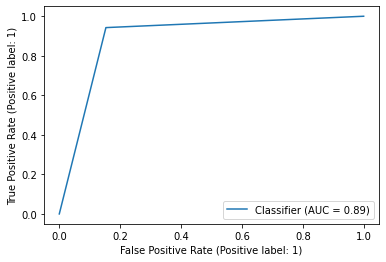

In [29]:
print("###LightGBM Classifier###\n")
print("Accuracy: " + str(mean(acc_score_lgb)) + " +- "+ str(std(acc_score_lgb)))
print("ROC-AUC: " + str(mean(auc_score_lgb)) + " +- " + str(std(auc_score_lgb)))
print("F1-Score: " + str(mean(f1_lgb)) +" +- "+ str(std(f1_lgb)))

yhat = lgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

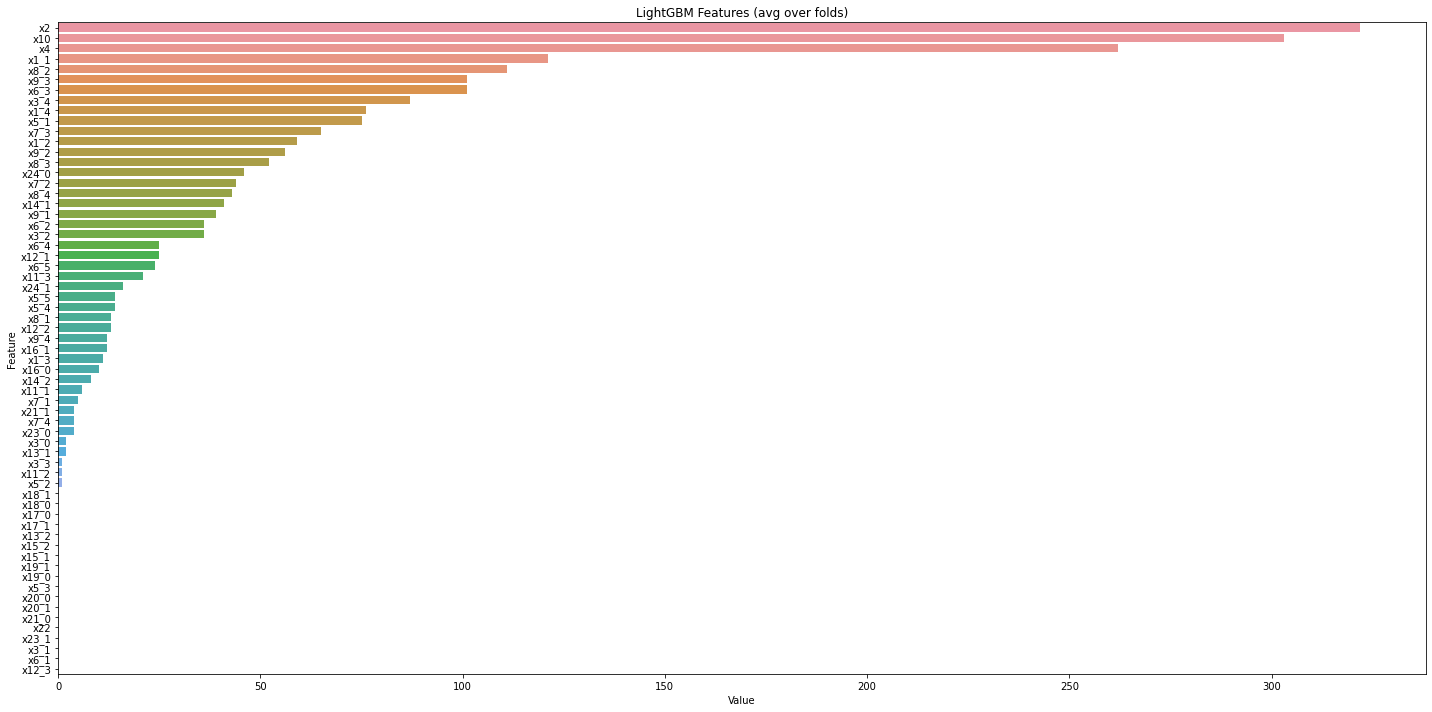

In [30]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [31]:
gc.collect()

20937

In [32]:
######## XGBoost model ##########

In [33]:
xgb  = XGBClassifier(
 learning_rate =0.05,
 n_estimators=410,
 max_depth=18,
 min_child_weight=4,
 subsample=0.5,
 objective= 'binary:logistic',
 random_state=42,
 tree_method='gpu_hist',
 gpu_id=0)

In [34]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_xgb = []
auc_score_xgb = []
f1_xgb = []
meta_train_xgb = []
meta_test_xgb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_xgb = np.append(meta_train_xgb, xgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_xgb) == 0:
        meta_test_xgb = xgb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_xgb = np.add(meta_test_xgb, xgb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = xgb.predict(X_test)
    acc_score_xgb.append(accuracy_score(yhat,y_test))
    auc_score_xgb.append(roc_auc_score(yhat,y_test))
    f1_xgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_xgb = np.divide(meta_test_xgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###XGBoost Classifier###

Accuracy: 0.8565656565656565 +- 0.006850838366793218
ROC-AUC: 0.8577644224950285 +- 0.006068994940501254
F1-Score: 0.8574011708066147 +- 0.006262034417034662
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        99
           1       0.88      0.82      0.85        99

    accuracy                           0.85       198
   macro avg       0.86      0.85      0.85       198
weighted avg       0.86      0.85      0.85       198



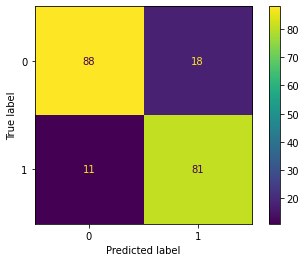

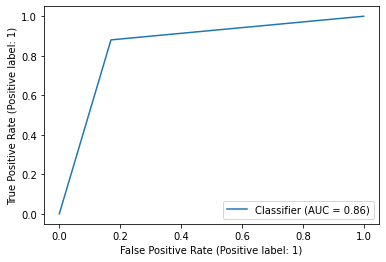

In [35]:
print("###XGBoost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_xgb)) + " +- "+ str(std(acc_score_xgb)))
print("ROC-AUC: " + str(mean(auc_score_xgb)) + " +- " + str(std(auc_score_xgb)))
print("F1-Score: " + str(mean(f1_xgb)) +" +- "+ str(std(f1_xgb)))

yhat = xgb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

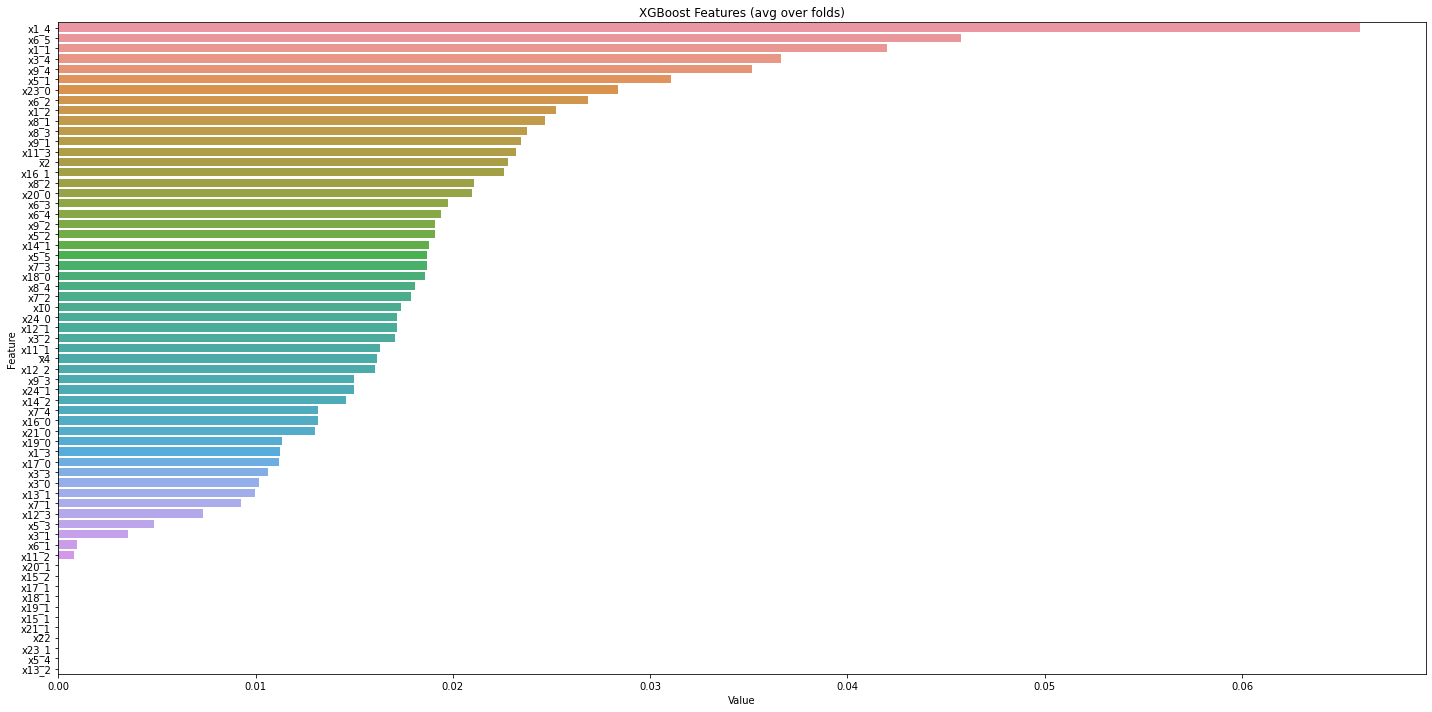

In [36]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [37]:
gc.collect()

20981

In [38]:
############ CatBoost ################

In [39]:
catb = CatBoostClassifier(iterations=450,
                           learning_rate=0.05,
                           depth=10,
                          task_type = "GPU")

In [40]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_catb = []
auc_score_catb = []
f1_catb = []
meta_train_catb = []
meta_test_catb = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    catb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_catb = np.append(meta_train_catb, catb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_catb) == 0:
        meta_test_catb = catb.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_catb = np.add(meta_test_catb, catb.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = catb.predict(X_test)
    acc_score_catb.append(accuracy_score(yhat,y_test))
    auc_score_catb.append(roc_auc_score(yhat,y_test))
    f1_catb.append(f1_score(yhat,y_test))
    i += 1
meta_test_catb = np.divide(meta_test_catb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###Catboost Classifier###

Accuracy: 0.8868686868686868 +- 0.009896928253669427
ROC-AUC: 0.8876876792333983 +- 0.009678895240806718
F1-Score: 0.8889211063609924 +- 0.009302223202091005
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        99
           1       0.86      0.89      0.88        99

    accuracy                           0.87       198
   macro avg       0.87      0.87      0.87       198
weighted avg       0.87      0.87      0.87       198



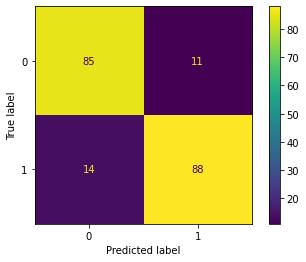

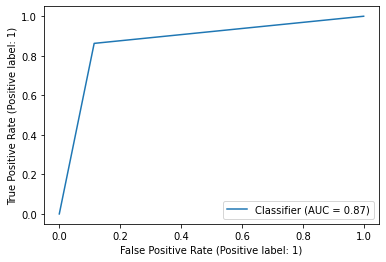

In [41]:
print("###Catboost Classifier###\n")
print("Accuracy: " + str(mean(acc_score_catb)) + " +- "+ str(std(acc_score_catb)))
print("ROC-AUC: " + str(mean(auc_score_catb)) + " +- " + str(std(auc_score_catb)))
print("F1-Score: " + str(mean(f1_catb)) +" +- "+ str(std(f1_catb)))

yhat = catb.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

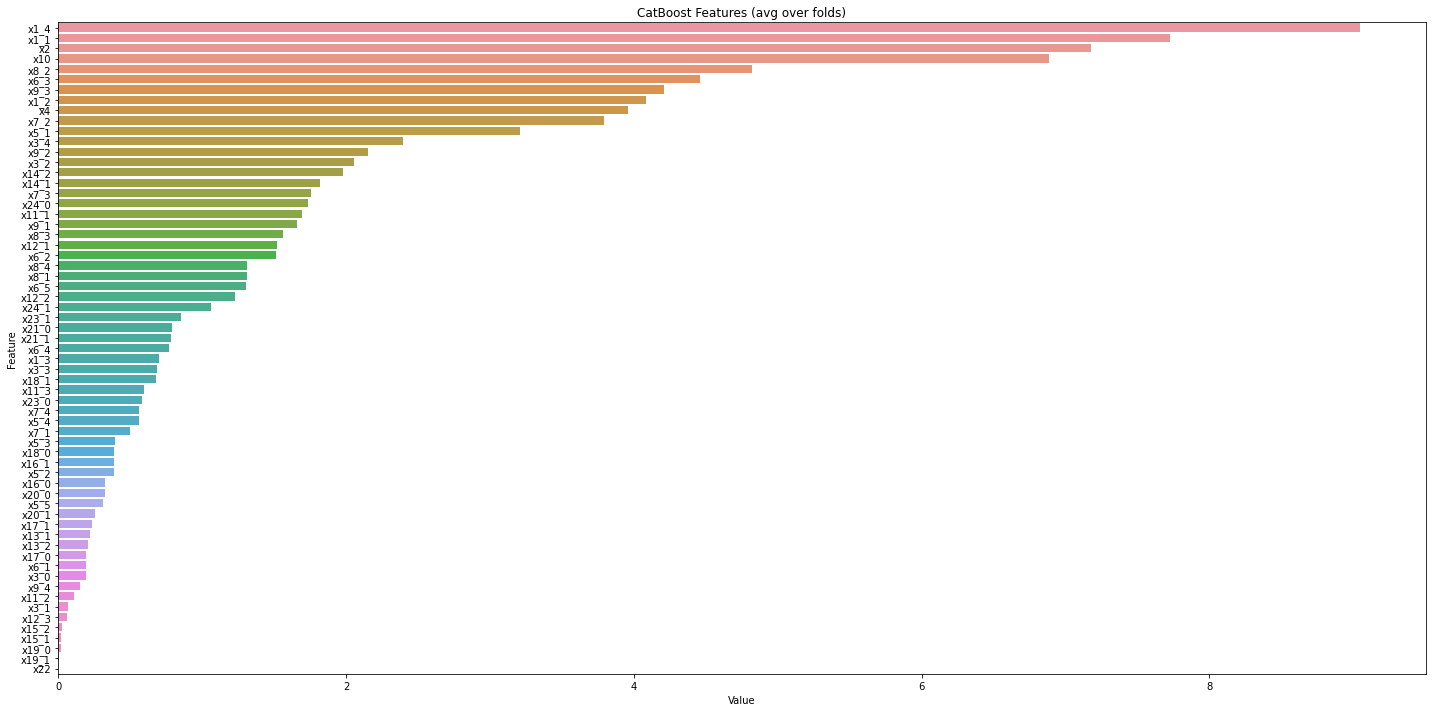

In [42]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(catb.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()


In [43]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% |  1% |


In [44]:
######### GBDT #############

In [45]:
gbdt = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [46]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_gbdt = []
auc_score_gbdt = []
f1_gbdt = []
meta_train_gbdt = []
meta_test_gbdt = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    gbdt.fit(train_X, train_y)
    ####meta
    meta_train_gbdt = np.append(meta_train_gbdt, gbdt.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_gbdt) == 0:
        meta_test_gbdt = gbdt.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_gbdt = np.add(meta_test_gbdt, gbdt.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = gbdt.predict(X_test)
    acc_score_gbdt.append(accuracy_score(yhat,y_test))
    auc_score_gbdt.append(roc_auc_score(yhat,y_test))
    f1_gbdt.append(f1_score(yhat,y_test))
    i += 1
meta_test_gbdt = np.divide(meta_test_gbdt, n_fold)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2732           0.0579            2.21s
         2           1.1893           0.0515            2.39s
         3           1.1135           0.0507            2.53s
         4           1.0614           0.0424            3.76s
         5           0.9975           0.0346            3.90s
         6           0.9420           0.0385            3.81s
         7           0.8873           0.0310            3.71s
         8           0.8342           0.0331            3.62s
         9           0.7853           0.0249            3.60s
        10           0.7454           0.0254            3.52s
        20           0.4604           0.0139            3.03s
        30           0.3007           0.0036            2.93s
        40           0.2128           0.0030            2.76s
        50           0.1392           0.0013            2.65s
        60           0.1043          -0.0003            

###GBDT Classifier###

Accuracy: 0.8939393939393939 +- 0.007824208780217012
ROC-AUC: 0.8942377937618284 +- 0.007856118370328161
F1-Score: 0.8940161197466896 +- 0.008025068861462833
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        99
           1       0.91      0.87      0.89        99

    accuracy                           0.89       198
   macro avg       0.89      0.89      0.89       198
weighted avg       0.89      0.89      0.89       198



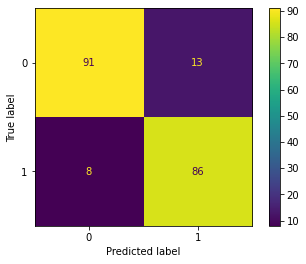

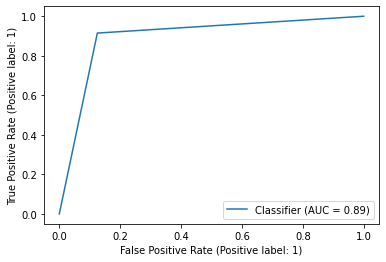

In [47]:
print("###GBDT Classifier###\n")
print("Accuracy: " + str(mean(acc_score_gbdt)) + " +- "+ str(std(acc_score_gbdt)))
print("ROC-AUC: " + str(mean(auc_score_gbdt)) + " +- " + str(std(auc_score_gbdt)))
print("F1-Score: " + str(mean(f1_gbdt)) +" +- "+ str(std(f1_gbdt)))

yhat = gbdt.predict(X_test)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [48]:
gc.collect()

3763

In [49]:
########### 1D-CNN model #############

In [50]:
def EarlyStop(patience):
    return EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(
                     filepath=model_name, 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 )   

In [51]:
# Define 1D - CNN model
def create_model(input_shape):
    # Model Building
    model = Sequential()
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(input_shape,1)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_train.shape[1], 1)

# 1D-CNN model
cnn1d = create_model(input_shape = X_train_cnn.shape[1])   

In [52]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d = []
auc_score_cnn1d = []
f1_cnn1d = []
meta_train_cnn1d = []
meta_test_cnn1d = []
i = 1
for train_index, valid_index in kf.split(X_train_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train_cnn[train_index], X_train_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./cnn1d.h5')],
            verbose = 1)
    ####meta
    meta_train_cnn1d = np.append(meta_train_cnn1d, cnn1d.predict(val_X))
    
    if len(meta_test_cnn1d) == 0:
        meta_test_cnn1d = cnn1d.predict(X_test_cnn)
    else:
        meta_test_cnn1d = np.add(meta_test_cnn1d, cnn1d.predict(X_test_cnn))
    #####
    yhat = cnn1d.predict(X_test_cnn).round()
    acc_score_cnn1d.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d.append(roc_auc_score(yhat,y_test))
    f1_cnn1d.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d = np.divide(meta_test_cnn1d, n_fold)

KFold 1 of 5
Epoch 1/500
3/3 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.5968
Epoch 1: val_accuracy improved from -inf to 0.64557, saving model to ./cnn1d.h5
3/3 [==============================] - 4s 368ms/step - loss: 0.6753 - accuracy: 0.5968 - val_loss: 0.6095 - val_accuracy: 0.6456
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5889 - accuracy: 0.7422
Epoch 2: val_accuracy improved from 0.64557 to 0.74684, saving model to ./cnn1d.h5
3/3 [==============================] - 0s 35ms/step - loss: 0.5718 - accuracy: 0.7317 - val_loss: 0.5432 - val_accuracy: 0.7468
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5540 - accuracy: 0.7188
Epoch 3: val_accuracy improved from 0.74684 to 0.75949, saving model to ./cnn1d.h5
3/3 [==============================] - 0s 35ms/step - loss: 0.5359 - accuracy: 0.7365 - val_loss: 0.5232 - val_accuracy: 0.7595
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5408 - a

###1D-CNN Classifier###

Accuracy: 0.8979797979797979 +- 0.01789903550168621
ROC-AUC: 0.8999591093486629 +- 0.018496812813220815
F1-Score: 0.9009319019922511 +- 0.018279350258113003
7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        99
           1       0.89      0.94      0.92        99

    accuracy                           0.91       198
   macro avg       0.92      0.91      0.91       198
weighted avg       0.92      0.91      0.91       198



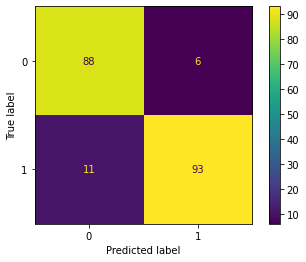

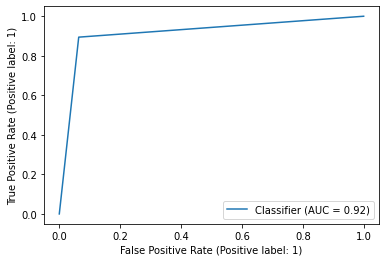

In [53]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(mean(acc_score_cnn1d)) + " +- "+ str(std(acc_score_cnn1d)))
print("ROC-AUC: " + str(mean(auc_score_cnn1d)) + " +- " + str(std(auc_score_cnn1d)))
print("F1-Score: " + str(mean(f1_cnn1d)) +" +- "+ str(std(f1_cnn1d)))

yhat = cnn1d.predict(X_test_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [54]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 38% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 45% |  1% |


In [55]:
########### TabNet #############

In [56]:
class roc_auc(Metric):
    def __init__(self):
        self._name = "roc_auc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        roc_auc = roc_auc_score(y_true, y_score[:, 1])
        return roc_auc

In [57]:
tabnet = TabNetClassifier(
                        n_d = 64,
                        n_a = 64,
                        n_steps = 3,
                        gamma = 1.3,
                        n_independent = 1,
                        n_shared = 2,
                        momentum = 0.02,
                        clip_value = None,
                        lambda_sparse = 1e-3,
                        optimizer_fn = torch.optim.Adam,
                        optimizer_params = dict(lr = 1e-3, weight_decay=1e-3),
                        scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                        scheduler_params = {'T_0':5,
                                            'eta_min':1e-4,
                                            'T_mult':1,
                                            'last_epoch':-1},
                        mask_type = 'entmax',
                        verbose = 1
)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [58]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_tabnet = []
auc_score_tabnet = []
f1_tabnet = []
meta_train_tabnet = []
meta_test_tabnet = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = X_train[train_index], X_train[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    tabnet.fit(train_X, train_y.ravel(),
      eval_set=[(val_X, val_y.ravel())],
      eval_metric=[roc_auc, "accuracy"],
      max_epochs = 500,
      patience = 50,
      batch_size = 256)
    ####meta
    meta_train_tabnet = np.append(meta_train_tabnet, tabnet.predict_proba(val_X)[:,1].reshape(-1,1))
    
    if len(meta_test_tabnet) == 0:
        meta_test_tabnet = tabnet.predict_proba(X_test)[:,1].reshape(-1,1)
    else:
        meta_test_tabnet = np.add(meta_test_tabnet, tabnet.predict_proba(X_test)[:,1].reshape(-1,1))
    #####
    yhat = tabnet.predict(X_test).round()
    acc_score_tabnet.append(accuracy_score(yhat,y_test))
    auc_score_tabnet.append(roc_auc_score(yhat,y_test))
    f1_tabnet.append(f1_score(yhat,y_test))
    i += 1
meta_test_tabnet = np.divide(meta_test_tabnet, n_fold)

KFold 1 of 5
epoch 0  | loss: 1.00709 | val_0_roc_auc: 0.52949 | val_0_accuracy: 0.48734 |  0:00:00s
epoch 1  | loss: 0.982   | val_0_roc_auc: 0.53878 | val_0_accuracy: 0.50633 |  0:00:00s
epoch 2  | loss: 0.81877 | val_0_roc_auc: 0.54279 | val_0_accuracy: 0.53797 |  0:00:00s
epoch 3  | loss: 0.81242 | val_0_roc_auc: 0.54776 | val_0_accuracy: 0.53797 |  0:00:00s
epoch 4  | loss: 0.83513 | val_0_roc_auc: 0.53942 | val_0_accuracy: 0.55063 |  0:00:00s
epoch 5  | loss: 0.77487 | val_0_roc_auc: 0.54599 | val_0_accuracy: 0.55696 |  0:00:00s
epoch 6  | loss: 0.75616 | val_0_roc_auc: 0.56587 | val_0_accuracy: 0.56962 |  0:00:00s
epoch 7  | loss: 0.66932 | val_0_roc_auc: 0.56747 | val_0_accuracy: 0.56962 |  0:00:01s
epoch 8  | loss: 0.69708 | val_0_roc_auc: 0.58093 | val_0_accuracy: 0.59494 |  0:00:01s
epoch 9  | loss: 0.69836 | val_0_roc_auc: 0.60337 | val_0_accuracy: 0.60759 |  0:00:01s
epoch 10 | loss: 0.63981 | val_0_roc_auc: 0.62917 | val_0_accuracy: 0.60759 |  0:00:01s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 0.86234 | val_0_roc_auc: 0.50033 | val_0_accuracy: 0.50633 |  0:00:00s
epoch 2  | loss: 0.84349 | val_0_roc_auc: 0.52361 | val_0_accuracy: 0.5     |  0:00:00s
epoch 3  | loss: 0.81685 | val_0_roc_auc: 0.5289  | val_0_accuracy: 0.51266 |  0:00:00s
epoch 4  | loss: 0.78137 | val_0_roc_auc: 0.55968 | val_0_accuracy: 0.5443  |  0:00:00s
epoch 5  | loss: 0.81194 | val_0_roc_auc: 0.59095 | val_0_accuracy: 0.57595 |  0:00:00s
epoch 6  | loss: 0.70983 | val_0_roc_auc: 0.60576 | val_0_accuracy: 0.57595 |  0:00:00s
epoch 7  | loss: 0.67774 | val_0_roc_auc: 0.59974 | val_0_accuracy: 0.55696 |  0:00:00s
epoch 8  | loss: 0.66218 | val_0_roc_auc: 0.58818 | val_0_accuracy: 0.5443  |  0:00:00s
epoch 9  | loss: 0.65023 | val_0_roc_auc: 0.58801 | val_0_accuracy: 0.5443  |  0:00:00s
epoch 10 | loss: 0.64253 | val_0_roc_auc: 0.60495 | val_0_accuracy: 0.55063 |  0:00:00s
epoch 11 | loss: 0.64158 | val_0_roc_auc: 0.62514 | val_0_accuracy: 0.55696 |  0:00:00s
epoch 12 | loss: 0.61909 | val_0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


KFold 3 of 5
epoch 0  | loss: 0.99253 | val_0_roc_auc: 0.48782 | val_0_accuracy: 0.50633 |  0:00:00s
epoch 1  | loss: 0.90463 | val_0_roc_auc: 0.47388 | val_0_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.89268 | val_0_roc_auc: 0.50978 | val_0_accuracy: 0.50633 |  0:00:00s
epoch 3  | loss: 0.85117 | val_0_roc_auc: 0.51058 | val_0_accuracy: 0.53797 |  0:00:00s
epoch 4  | loss: 0.8378  | val_0_roc_auc: 0.50641 | val_0_accuracy: 0.53165 |  0:00:00s
epoch 5  | loss: 0.84629 | val_0_roc_auc: 0.52821 | val_0_accuracy: 0.55696 |  0:00:00s
epoch 6  | loss: 0.80978 | val_0_roc_auc: 0.56619 | val_0_accuracy: 0.56962 |  0:00:00s
epoch 7  | loss: 0.69061 | val_0_roc_auc: 0.60369 | val_0_accuracy: 0.58228 |  0:00:00s
epoch 8  | loss: 0.71467 | val_0_roc_auc: 0.63654 | val_0_accuracy: 0.56962 |  0:00:00s
epoch 9  | loss: 0.72603 | val_0_roc_auc: 0.66314 | val_0_accuracy: 0.59494 |  0:00:00s
epoch 10 | loss: 0.66929 | val_0_roc_auc: 0.68077 | val_0_accuracy: 0.61392 |  0:00:00s
epoch 11 | loss: 0.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.98592 | val_0_roc_auc: 0.63196 | val_0_accuracy: 0.5414  |  0:00:00s
epoch 1  | loss: 0.93    | val_0_roc_auc: 0.62341 | val_0_accuracy: 0.5414  |  0:00:00s
epoch 2  | loss: 0.80279 | val_0_roc_auc: 0.64018 | val_0_accuracy: 0.57962 |  0:00:00s
epoch 3  | loss: 0.82801 | val_0_roc_auc: 0.62716 | val_0_accuracy: 0.57325 |  0:00:00s
epoch 4  | loss: 0.8238  | val_0_roc_auc: 0.61788 | val_0_accuracy: 0.58599 |  0:00:00s
epoch 5  | loss: 0.80887 | val_0_roc_auc: 0.60029 | val_0_accuracy: 0.57962 |  0:00:00s
epoch 6  | loss: 0.72515 | val_0_roc_auc: 0.60534 | val_0_accuracy: 0.6051  |  0:00:00s
epoch 7  | loss: 0.71592 | val_0_roc_auc: 0.61234 | val_0_accuracy: 0.59873 |  0:00:00s
epoch 8  | loss: 0.70632 | val_0_roc_auc: 0.62927 | val_0_accuracy: 0.61146 |  0:00:00s
epoch 9  | loss: 0.69588 | val_0_roc_auc: 0.63839 | val_0_accuracy: 0.6051  |  0:00:00s
epoch 10 | loss: 0.69583 | val_0_roc_auc: 0.65484 | val_0_accuracy: 0.64331 |  0:00:00s
epoch 11 | loss: 0.65265 | val_0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.90139 | val_0_roc_auc: 0.56083 | val_0_accuracy: 0.56688 |  0:00:00s
epoch 3  | loss: 0.83639 | val_0_roc_auc: 0.56703 | val_0_accuracy: 0.56688 |  0:00:00s
epoch 4  | loss: 0.80112 | val_0_roc_auc: 0.59165 | val_0_accuracy: 0.58599 |  0:00:00s
epoch 5  | loss: 0.84815 | val_0_roc_auc: 0.60453 | val_0_accuracy: 0.59236 |  0:00:00s
epoch 6  | loss: 0.75757 | val_0_roc_auc: 0.62166 | val_0_accuracy: 0.61783 |  0:00:00s
epoch 7  | loss: 0.6951  | val_0_roc_auc: 0.62019 | val_0_accuracy: 0.6242  |  0:00:00s
epoch 8  | loss: 0.73445 | val_0_roc_auc: 0.62671 | val_0_accuracy: 0.66879 |  0:00:00s
epoch 9  | loss: 0.70392 | val_0_roc_auc: 0.62427 | val_0_accuracy: 0.64331 |  0:00:00s
epoch 10 | loss: 0.76807 | val_0_roc_auc: 0.63258 | val_0_accuracy: 0.65605 |  0:00:00s
epoch 11 | loss: 0.64119 | val_0_roc_auc: 0.64889 | val_0_accuracy: 0.64968 |  0:00:00s
epoch 12 | loss: 0.65641 | val_0_roc_auc: 0.66259 | val_0_accuracy: 0.64968 |  0:00:00s
epoch 13 | loss: 0.66964 | val_0

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.808080808080808 +- 0.01690222275826414
ROC-AUC: 0.8292586525651042 +- 0.021094859397508388
F1-Score: 0.8293162400609994 +- 0.016311192016817615
              precision    recall  f1-score   support

           0       0.90      0.71      0.79        99
           1       0.76      0.92      0.83        99

    accuracy                           0.81       198
   macro avg       0.83      0.81      0.81       198
weighted avg       0.83      0.81      0.81       198



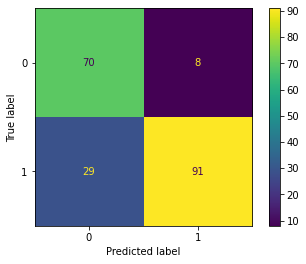

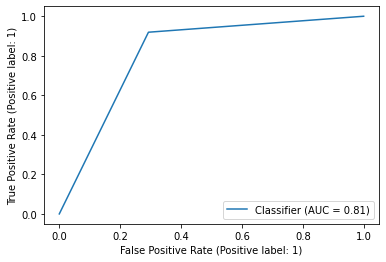

In [59]:
print("Accuracy: " + str(mean(acc_score_tabnet)) + " +- "+ str(std(acc_score_tabnet)))
print("ROC-AUC: " + str(mean(auc_score_tabnet)) + " +- " + str(std(auc_score_tabnet)))
print("F1-Score: " + str(mean(f1_tabnet)) +" +- "+ str(std(f1_tabnet)))


yhat = tabnet.predict(X_test).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

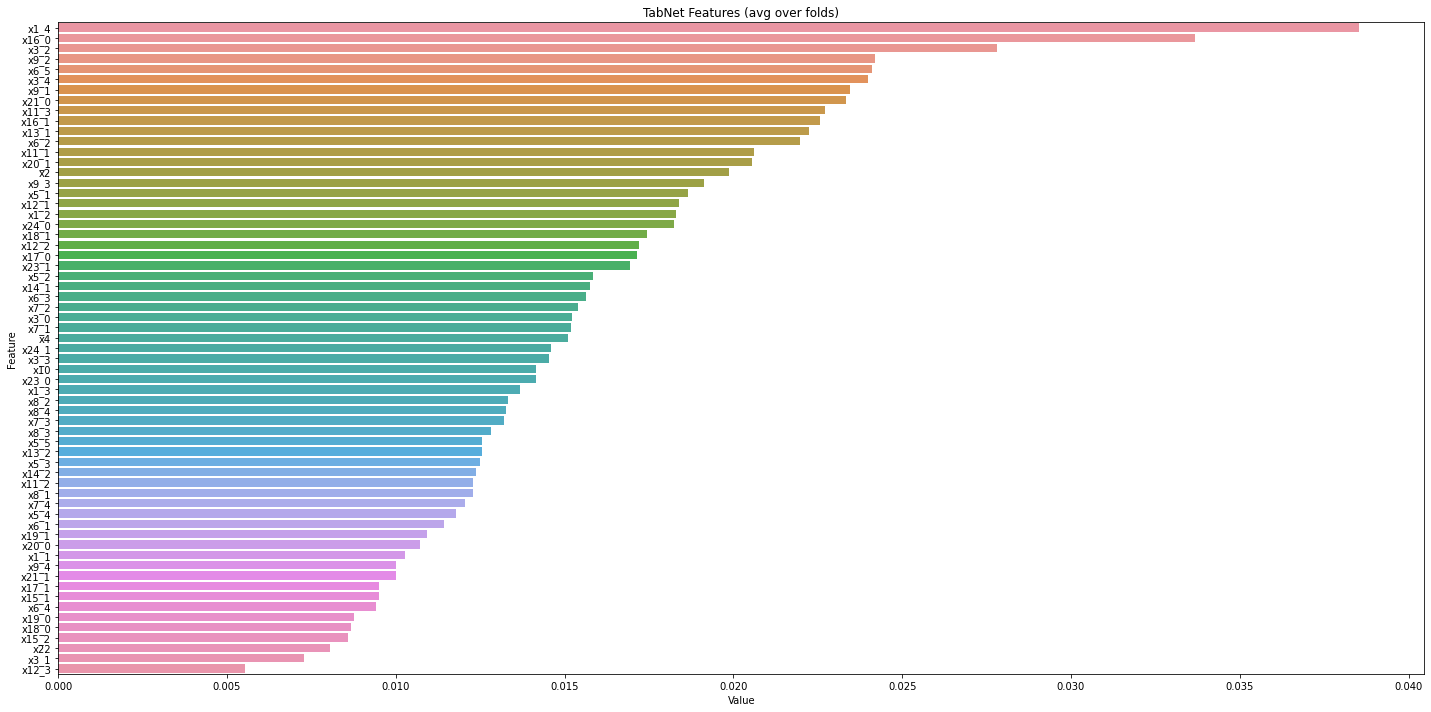

In [60]:
# feature_importances
feature_imp = pd.DataFrame(sorted(zip(tabnet.feature_importances_,df.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TabNet Features (avg over folds)')
plt.tight_layout()
plt.show()

In [61]:
gc.collect()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |


In [62]:
################# STACKING #####################

In [63]:
meta_train = pd.concat([ pd.DataFrame(X_train, columns=df.columns),
                          pd.DataFrame(meta_train_rf, columns=['RF']),
                          pd.DataFrame(meta_train_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_train_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_train_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_train_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_train_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_train_tabnet, columns=['TabNet'])], axis = 1)

In [64]:
meta_test = pd.concat([pd.DataFrame(X_test, columns=df.columns),
                          pd.DataFrame(meta_test_rf, columns=['RF']),
                          pd.DataFrame(meta_test_lgb, columns=['LightGBM']),                        
                       pd.DataFrame(meta_test_xgb, columns=['XGBoost']),
                     pd.DataFrame(meta_test_catb, columns=['CatBoost']),
                        pd.DataFrame(meta_test_gbdt, columns=['GBDT']),
                        pd.DataFrame(meta_test_cnn1d, columns=['1DCNN']),
                       pd.DataFrame(meta_test_tabnet, columns=['TabNet'])], axis = 1)

In [65]:
meta_train.head()

,x2,x4,x10,x22,x1_1,x1_2,x1_3,x1_4,x3_0,x3_1,...,x23_1,x24_0,x24_1,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,0.370128,-0.622421,1.247004,0.0,-0.537733,-0.597741,3.732323,-0.896310,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.246537,0.111081,0.377182,0.127579,1.461737e-05,2.493337e-05,0.902485
1,-0.730399,-0.805449,0.087308,0.0,-0.537733,-0.597741,-0.267930,1.115686,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.024931,0.002233,0.042549,0.004931,9.580502e-08,3.945926e-09,0.082646
2,-0.730399,0.018174,-0.879105,0.0,-0.537733,1.672966,-0.267930,-0.896310,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.396122,0.573724,0.454023,0.691929,3.732376e-01,9.964240e-01,0.880621
3,-0.913820,-0.210610,1.730210,0.0,1.859659,-0.597741,-0.267930,-0.896310,-0.159872,-0.169842,...,2.492686,1.693361,-1.693361,0.238227,0.027543,0.185610,0.094088,2.444649e-05,2.183224e-03,0.427414
4,-0.730399,-0.713935,0.957080,0.0,-0.537733,-0.597741,-0.267930,1.115686,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.041551,0.000561,0.031696,0.005254,1.421073e-07,7.681111e-09,0.000019


In [66]:
meta_test.head()

,x2,x4,x10,x22,x1_1,x1_2,x1_3,x1_4,x3_0,x3_1,...,x23_1,x24_0,x24_1,RF,LightGBM,XGBoost,CatBoost,GBDT,1DCNN,TabNet
0,-0.180136,-0.256367,-0.879105,0.0,-0.537733,-0.597741,-0.26793,1.115686,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.095845,0.042654,0.095623,0.021409,0.000009,5.424607e-09,0.028998
1,-0.730399,-0.805449,-1.169028,0.0,-0.537733,1.672966,-0.26793,-0.896310,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.451524,0.367005,0.363708,0.426879,0.505356,1.513600e-05,0.558497
2,-1.280662,-0.302124,-0.395898,0.0,-0.537733,1.672966,-0.26793,-0.896310,-0.159872,-0.169842,...,-0.401174,1.693361,-1.693361,0.486981,0.131585,0.511485,0.430134,0.003325,4.064293e-01,0.393737
3,0.370128,-0.622421,-0.879105,0.0,-0.537733,1.672966,-0.26793,-0.896310,-0.159872,-0.169842,...,2.492686,1.693361,-1.693361,0.468698,0.439925,0.564694,0.457325,0.669094,8.114470e-01,0.294131
4,-0.180136,-0.713935,2.599982,0.0,-0.537733,1.672966,-0.26793,-0.896310,-0.159872,-0.169842,...,-0.401174,-0.590542,0.590542,0.476454,0.623854,0.506070,0.570674,0.748865,6.574454e-01,0.002575


In [67]:
meta_train.to_pickle('./drive/MyDrive/meta_train.pkl')
meta_test.to_pickle('./drive/MyDrive/meta_test.pkl')

y_train.to_pickle('./drive/MyDrive/y_train.pkl')
y_test.to_pickle('./drive/MyDrive/y_test.pkl')

In [68]:
########### Stacking level 1 ###############

In [69]:
stacking_lv1_xgb  = XGBClassifier(
 learning_rate =0.05,
 n_estimators=410,
 max_depth=18,
 min_child_weight=4,
 subsample=0.5,
 objective= 'binary:logistic',
 random_state=42,
 tree_method='gpu_hist',
 gpu_id=0)

In [70]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv1_xgb = []
auc_score_stacking_lv1_xgb = []
f1_stacking_lv1_xgb = []
meta_train_stacking_lv1_xgb = []
meta_test_stacking_lv1_xgb = []
i = 1
for train_index, valid_index in kf.split(meta_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train.iloc[train_index], meta_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv1_xgb.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_stacking_lv1_xgb = np.append(meta_train_stacking_lv1_xgb, stacking_lv1_xgb.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv1_xgb) == 0:
        meta_test_stacking_lv1_xgb = stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv1_xgb = np.add(meta_test_stacking_lv1_xgb, stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv1_xgb.predict(meta_test)
    acc_score_stacking_lv1_xgb.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv1_xgb.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv1_xgb.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv1_xgb = np.divide(meta_test_stacking_lv1_xgb, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


Accuracy: 0.906060606060606 +- 0.011338355717496779
ROC-AUC: 0.9075425308901585 +- 0.011103937583414493
F1-Score: 0.9067744709305451 +- 0.013745637810615339
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        99
           1       0.89      0.93      0.91        99

    accuracy                           0.91       198
   macro avg       0.91      0.91      0.91       198
weighted avg       0.91      0.91      0.91       198



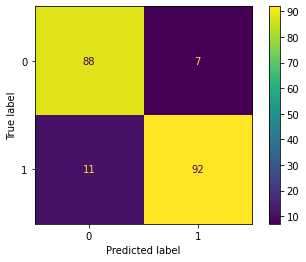

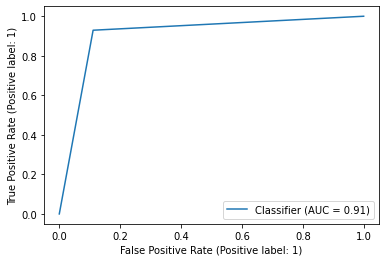

In [71]:
yhat = stacking_lv1_xgb.predict(meta_test)
print("Accuracy: " + str(mean(acc_score_stacking_lv1_xgb)) + " +- "+ str(std(acc_score_stacking_lv1_xgb)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv1_xgb)) + " +- " + str(std(auc_score_stacking_lv1_xgb)))
print("F1-Score: " + str(mean(f1_stacking_lv1_xgb)) +" +- "+ str(std(f1_stacking_lv1_xgb)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [72]:
stacking_lv1_gbdt  = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [73]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv1_gbdt = []
auc_score_stacking_lv1_gbdt = []
f1_stacking_lv1_gbdt = []
meta_train_stacking_lv1_gbdt = []
meta_test_stacking_lv1_gbdt = []
i = 1
for train_index, valid_index in kf.split(meta_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train.iloc[train_index], meta_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv1_gbdt.fit(train_X, train_y)
    ####meta
    meta_train_stacking_lv1_gbdt = np.append(meta_train_stacking_lv1_gbdt, stacking_lv1_gbdt.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv1_gbdt) == 0:
        meta_test_stacking_lv1_gbdt = stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv1_gbdt = np.add(meta_test_stacking_lv1_gbdt, stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv1_gbdt.predict(meta_test)
    acc_score_stacking_lv1_gbdt.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv1_gbdt.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv1_gbdt.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv1_gbdt = np.divide(meta_test_stacking_lv1_gbdt, n_fold)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2699           0.1045            1.23s
         2           1.1716           0.0908            1.43s
         3           1.0812           0.0823            1.46s
         4           1.0036           0.0740            1.56s
         5           0.9307           0.0659            1.61s
         6           0.8703           0.0644            1.61s
         7           0.8109           0.0597            1.66s
         8           0.7466           0.0478            1.69s
         9           0.6929           0.0457            1.74s
        10           0.6473           0.0413            1.75s
        20           0.3455           0.0202            1.93s
        30           0.1896           0.0098            1.96s
        40           0.1150           0.0050            2.02s
        50           0.0712           0.0024            2.00s
        60           0.0445           0.0016            

Accuracy: 0.9181818181818182 +- 0.004948464126834708
ROC-AUC: 0.9187704320924357 +- 0.004834889767130515
F1-Score: 0.9194133661075241 +- 0.004612282185497734
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        99
           1       0.92      0.93      0.92        99

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



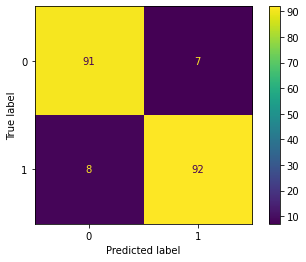

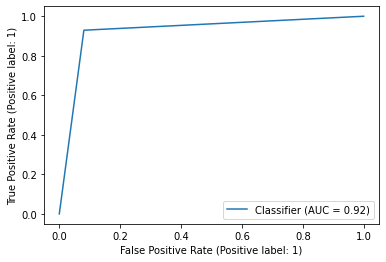

In [74]:
yhat = stacking_lv1_gbdt.predict(meta_test)
print("Accuracy: " + str(mean(acc_score_stacking_lv1_gbdt)) + " +- "+ str(std(acc_score_stacking_lv1_gbdt)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv1_gbdt)) + " +- " + str(std(auc_score_stacking_lv1_gbdt)))
print("F1-Score: " + str(mean(f1_stacking_lv1_gbdt)) +" +- "+ str(std(f1_stacking_lv1_gbdt)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [75]:
######### Stacking level 2 ##########

In [76]:
meta_train_lv1 = pd.concat([#meta_train,
                          pd.DataFrame(stacking_lv1_xgb.predict_proba(meta_train)[:,1].reshape(-1,1), columns=['lv1_xgb_train']),
                       pd.DataFrame(stacking_lv1_gbdt.predict_proba(meta_train)[:,1].reshape(-1,1), columns=['lv1_gbdt_train']),
                        ], axis = 1)

In [77]:
meta_test_lv1 = pd.concat([#meta_test,
                           pd.DataFrame(stacking_lv1_xgb.predict_proba(meta_test)[:,1].reshape(-1,1), columns=['lv1_xgb_test']),
                       pd.DataFrame(stacking_lv1_gbdt.predict_proba(meta_test)[:,1].reshape(-1,1), columns=['lv1_gbdt_test']),
                        ], axis = 1)

In [78]:
stacking_lv2_lr = LogisticRegression(random_state=0)

In [79]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_lv2_lr = []
auc_score_stacking_lv2_lr = []
f1_stacking_lv2_lr = []
meta_train_stacking_lv2_lr = []
meta_test_stacking_lv2_lr = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv1, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv1.iloc[train_index], meta_train_lv1.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_lv2_lr.fit(train_X, train_y)
    ####meta
    meta_train_stacking_lv2_lr = np.append(meta_train_stacking_lv2_lr, stacking_lv2_lr.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_lv2_lr) == 0:
        meta_test_stacking_lv2_lr = stacking_lv2_lr.predict_proba(meta_test_lv1)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_lv2_lr = np.add(meta_test_stacking_lv2_lr, stacking_lv2_lr.predict_proba(meta_test_lv1)[:,1].reshape(-1,1))
    #####
    yhat = stacking_lv2_lr.predict(meta_test_lv1)
    acc_score_stacking_lv2_lr.append(accuracy_score(yhat,y_test))
    auc_score_stacking_lv2_lr.append(roc_auc_score(yhat,y_test))
    f1_stacking_lv2_lr.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_lv2_lr = np.divide(meta_test_stacking_lv2_lr, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


Accuracy: 0.9242424242424242 +- 0.0
ROC-AUC: 0.9242857142857142 +- 1.1102230246251565e-16
F1-Score: 0.9246231155778893 +- 1.1102230246251565e-16
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        99
           1       0.92      0.93      0.92        99

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



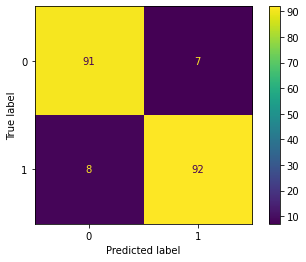

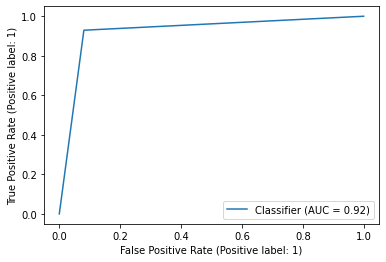

In [80]:
yhat = stacking_lv2_lr.predict(meta_test_lv1)
print("Accuracy: " + str(mean(acc_score_stacking_lv2_lr)) + " +- "+ str(std(acc_score_stacking_lv2_lr)))
print("ROC-AUC: " + str(mean(auc_score_stacking_lv2_lr)) + " +- " + str(std(auc_score_stacking_lv2_lr)))
print("F1-Score: " + str(mean(f1_stacking_lv2_lr)) +" +- "+ str(std(f1_stacking_lv2_lr)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()